In [1]:
import math
import networkx as nx
import pandas as pd
import numpy as np
from scipy.special import zeta
from scipy import stats
import igraph

In [2]:
# load dataset
data = pd.read_csv('facebook-links.txt', sep="\t", header=None)

In [3]:
# clean dataset

# remove time-stamp column
data = data.drop([2], axis=1)

In [4]:
# since it is an undirected graph, no parallel edges are added
G = nx.Graph()
G.add_edges_from(data.itertuples(index=False))

# 1. Compute the diameter of the largest connected component.

In [5]:
# obtain the largest connected component

# networkx implementation is to slow to compute...
# lccs = sorted(nx.connected_components(G), key=len, reverse=True)
# lcc = G.subgraph(lccs[0])
# get the diameter of this component
# print(f"The diameter of the largest connected component is {nx.algorithms.distance_measures.diameter(lcc)}.")

G_igraph = igraph.Graph.TupleList(G.edges(), directed=False)
cc = G_igraph.clusters()
lcc_igraph = cc.giant()
print(f"The diameter of the largest connected component is {lcc_igraph.diameter()}.")

The diameter of the largest connected component is 15.


# 2. Determine the ID of the node with the highest degree. Report both the ID and the degree.

In [6]:
# get node with highest degree
print(f"The node with the highest degree hast the ID {sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]} and a degree of {sorted(G.degree, key=lambda x: x[1], reverse=True)[0][1]}.")

The node with the highest degree hast the ID 2332 and a degree of 1098.


# 3. Compute the number of triangles in the network.

In [7]:
number_of_triangles = sum(nx.triangles(G).values()) / 3
print(f"The number of triangles in the network is {int(number_of_triangles)}.")

The number of triangles in the network is 3501542.


# 4. Compute the global (or average local) clustering coefficient of the network.

In [8]:
print(f"The global clustering coefficient of the network is {nx.average_clustering(G)}.")

The global clustering coefficient of the network is 0.22099367691190397.


# 5. Determine the power-law exponent of the degree distribution.

In [7]:
import powerlaw as pl

In [104]:
degrees = sorted(G.degree, key=lambda x: x[1], reverse=False)
degrees_unique = set([deg[1] for deg in degrees])

In [123]:
def calc_P_k(gamma, k, K_min):
    return 1- zeta(gamma, k)/zeta(gamma, K_min)

# iterate over possible K_min
N = len(degrees)
k = [deg[1] for deg in degrees]
K_min_best = None
gamma_best = None
D_min = math.inf
for node_degree in degrees_unique:
    K_min = node_degree
    degrees
    # calculate gamma
    gamma = 1 + 1 / ((1/N * np.sum(np.log([deg[1] for deg in degrees]))) - np.log(K_min - 0.5))
   
    # kolmogorov-smirnov test
    k_cdf, S = pl.cdf(k, linear_bins=True)
    
    D_max = 0
    for i, k_i in enumerate(k_cdf):
        # k must be greater or equal K_min
        if k_i >= K_min:
            D = abs(S[i] - calc_P_k(gamma, k_i, K_min))
            if D > D_max:
                D_max = D
    #D = max([abs(p_k - S[i]) for i, p_k in enumerate(P_k)])
    if D_max <= D_min:
        D_min = D_max
        K_min_best = K_min
        gamma_best = gamma
        
print(f"The power-law exponent of the degree distribution is {gamma_best}.")

The power-law exponent of the degree distribution is 0.7868314661942882.


### trying the approach from the tutorial to see, if we can get a better result...

In [124]:
degrees = sorted(G.degree, key=lambda x: x[1], reverse=False)
degrees_unique = set([deg[1] for deg in degrees])
min_degree = min(degrees_unique)
def estimate_gamma(n, k_min):
    gamma = (1 + 1 / ((1/len(n) * np.sum(np.log(n))) - np.log(K_min - 0.5)))
    #print(gamma)
    return gamma
def cdf(gamma, k, k_min):
    return 1 - zeta(gamma, k) / zeta(gamma, k_min)
def ks_test(n, k_min):
    k, p = pl.cdf(n, linear=True)
    #print(p)
    gamma = estimate_gamma(n, k_min)
    #diff = [p[i] - cdf(gamma, k[i], k_min) for i in range(len(k))]
    diff = []
    for i in range(len(k)):
        diff.append(p[i] - cdf(gamma, k[i], k_min))
    
    return gamma, max(diff)

In [125]:
test_results = []
gammas = []

for k_min in range(min_degree, max(degrees_unique)):
    n = [k for k in [deg[1] for deg in degrees] if k >= k_min]
    gamma, test_result = ks_test(n, k_min)
    test_results.append(test_result)
    gammas.append(gamma)
    
best_estimate = min(test_results)
best_k_min = test_results.index(best_estimate) + min_degree

gamma_best = gammas[test_results.index(best_estimate)]

/opt/anaconda3/envs/complexnetworkanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [126]:
gamma_best

0.7868314661942882

### We tried two approaches and both result in non fitting gamma. The reason for this is that the zeta function returns nan for some gamma and k_min combinations...

# 6. Create a plot showing both the original degree distribution and the result of your fit.

In [10]:
import matplotlib.pyplot as plt

gamma: 1.4329629853425812


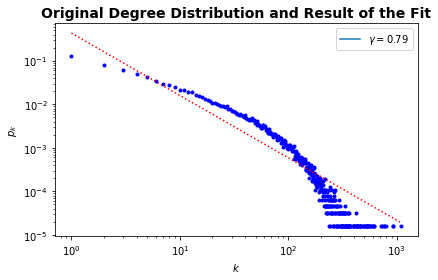

<Figure size 432x288 with 0 Axes>

In [127]:
x, y = pl.pdf(k, linear_bins=True)
fit = pl.Fit(k, xmin=1)
fit_x = np.linspace(min(x), max(x), 1000)
fit_y = ((gamma_best - 1)* K_min_best ** (gamma_best - 1)) * fit_x ** (-gamma_best)

print(f"gamma: {fit.alpha}")

fig, ax = plt.subplots()

ax.loglog(x[:-1], y, "b.")
fit.power_law.plot_pdf(ax=ax, linestyle=":", color="r")
ax.set_title("Original Degree Distribution and Result of the Fit", fontweight="bold", fontsize=14)
ax.set_ylabel("$p_k$")
ax.set_xlabel("$k$")
fig.tight_layout()
plt.plot(fit_x, fit_y, label=f"$\gamma = {round(gamma_best,2)}$")
ax.legend()
plt.show(fig)